In [130]:
#Multiclass classification for only setting after multi-label models were not performing well, so we will try multiclass classification for setting only.

In [131]:
#https://pypi.org/project/rawpy/

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pandas import DataFrame
from torch import nn
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import os

In [133]:
!pip install torcheval

python(92004) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [134]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #Numpy and Pandas FutureWarnings - ignore them for now, we can fix them later

In [135]:
df = pd.read_csv('../categories.csv')
df.head()

,img_name,location,time_of_day,skyCondition,setting
0,a0001-jmac_DSC1459,outdoor,day,sun_sky,nature
1,a0002-dgw_005,indoor,day,mixed,people
2,a0003-NKIM_MG_8178,outdoor,day,sun_sky,man_made
3,a0004-jmac_MG_1384,outdoor,day,sun_sky,nature
4,a0005-jn_2007_05_10__564,outdoor,day,sun_sky,man_made


In [136]:
df = df.drop(columns=['location','time_of_day','skyCondition']) # Drop other columns, we will use 'setting' as the target variable, input will be the image.

In [137]:
df = pd.get_dummies(df, columns=['setting'], dtype='int')
df.columns

Index(['img_name', 'setting_abstract', 'setting_animals', 'setting_man_made',
       'setting_nature', 'setting_people'],
      dtype='object')

In [138]:
df.drop('setting_abstract', axis=1, inplace=True)
df.head()

,img_name,setting_animals,setting_man_made,setting_nature,setting_people
0,a0001-jmac_DSC1459,0,0,1,0
1,a0002-dgw_005,0,0,0,1
2,a0003-NKIM_MG_8178,0,1,0,0
3,a0004-jmac_MG_1384,0,0,1,0
4,a0005-jn_2007_05_10__564,0,1,0,0


In [139]:
device = torch.device("mps")

In [140]:
from torchvision.io import decode_image
from torchvision.io import ImageReadMode


class ImageDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.transform = transform
        self.img_dir = img_dir
        self.bounds = []

        if not self.img_dir:
            raise ValueError(f"No images found in directory: {img_dir}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = row['img_name']  # Assuming the first column is 'img_name'
        #Get the label tensor from the row, excluding the first column (img_name)
        label = torch.tensor(row[1:], dtype=torch.long)  # Convert the labels to tensor (excluding img_name, which is the input image name)

        img_path = os.path.join(self.img_dir, img_name) + ".jpg" # Full path to the image file
        image = decode_image(img_path, mode=ImageReadMode.RGB) #outputs tensor of shape (C, H, W) where C is the number of channels, H is the height and W is the width

        if self.transform:
            image = self.transform(image)

        return image, label # Exclude the first column (img_name) from the label tensor

In [141]:
# Transformations for the dataset

# These are the standard transformations for the dataset, we will use these for training, testing, and validation
val_test_standard_transforms = transforms.Compose([
    transforms.ToPILImage(), # Convert numpy array to PIL Image
    transforms.Resize((512, 512)), # Resize the image to 512x512 for consistency and to match the model input size
    transforms.ToTensor(), # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


/opt/anaconda3/envs/fivekClassiferModelV2UpdatedPy/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [142]:
#Doing data augmentation for training set to get more data and prevent overfitting
#These are applied to the training set only, not the validation or test set
#They are applied dynamically during training, so sample images will be different each time, effectively increasing the size of the training set


#Training transformations with data augmentation
training_augmentation_transforms = transforms.Compose([
    #Standard transformations for the dataset, we will still use these for training (rest below)
    transforms.ToPILImage(), # Convert numpy array to PIL Image
    #Data augmentation transformations for training
    # p= probability of applying the transformation, 0.2 means 20% chance of applying the transformation
    transforms.RandomHorizontalFlip(p=0.2), # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(p=0.2), # Randomly flip the image vertically

    #RandomApply makes any transformation randomly applied with a probability p, so we can apply the same transformation with a probability of 0.2

    #30% chance of:
    transforms.RandomApply(
        [
            transforms.RandomCrop(size=430, pad_if_needed=True)
        ], # Randomly crop the image to 430 in random locations, pad if needed to maintain the size for input to the model (82 pixels on each side, so 82+430+82=512)
        p=0.2),

    transforms.RandomAdjustSharpness(sharpness_factor=2,p=0.2), # Randomly adjust the sharpness of the image
    transforms.RandomAdjustSharpness(sharpness_factor=0.5,p=0.2), # Randomly adjust the sharpness of the image


    transforms.RandomGrayscale(p=0.2), # Randomly convert the image to grayscale with a probability of 0.1
    #The rest of the standard transformations

    transforms.Resize((512, 512)), # Resize the image to 512x512 for consistency and to match the model input size
    transforms.ToTensor(), # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

/opt/anaconda3/envs/fivekClassiferModelV2UpdatedPy/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Add data augmentation depending on overfitting

In [143]:
from sklearn.model_selection import train_test_split
# Split the dataset into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42) # 70% training, 30% test
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)  # Split the test set into validation and test sets
#This gives us 70% training, 15% validation, and 15% test sets

In [144]:
train_dataset = ImageDataset(train_df, img_dir='../raw_images_organised', transform=training_augmentation_transforms)  # Create the training dataset with data augmentation
test_dataset = ImageDataset(test_df, img_dir='../raw_images_organised', transform=val_test_standard_transforms)  # Create the test dataset with standard transformations
val_dataset = ImageDataset(val_df, img_dir='../raw_images_organised', transform=val_test_standard_transforms)  # Create the validation dataset with standard transformations

In [145]:
print(train_dataset.transform)
print(test_dataset.transform)
print(val_dataset.transform)

Compose(
      ToPILImage()
      RandomHorizontalFlip(p=0.2)
      RandomVerticalFlip(p=0.2)
      RandomApply(    RandomCrop(size=(430, 430), pad_if_needed=True, fill=0, padding_mode=constant))
      RandomAdjustSharpness(p=0.2, sharpness_factor=2)
      RandomAdjustSharpness(p=0.2, sharpness_factor=0.5)
      RandomGrayscale(p=0.2)
      Resize(size=[512, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToTensor()
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)
Compose(
      ToPILImage()
      Resize(size=[512, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToTensor()
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)
Compose(
      ToPILImage()
      Resize(size=[512, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToTensor()
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)


In [146]:
#Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [147]:
train_images, train_labels = next(iter(train_loader))
print(train_images.shape, train_labels.shape)

torch.Size([16, 3, 512, 512]) torch.Size([16, 4])


torch.float32
torch.int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


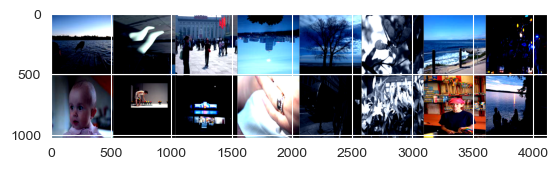

In [148]:
from torchvision.utils import make_grid

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print(train_images.dtype)  # Check the shape of the images tensor
print(train_labels.dtype)  # Check the shape of the labels tensor

imshow(make_grid(train_images))

Look at flosst code for data augmentation and transforms

In [149]:
#n_samples / (n_classes * np.bincount(y))

#Build my own class weight function

def class_weights(data: DataFrame):
    weights = []
    for col in data.columns[1:]:  # Skip the first column (img_name)
        classes = data[col].unique()
        total_samples = len(data[col])
        class_weight = total_samples / (len(classes) * data[col].value_counts())
        weights.append(class_weight[1]) # Assuming the positive class is the second one (1)
    class_weights = torch.tensor(weights, dtype=torch.float32)

    return class_weights

In [150]:
weights = class_weights(df)
print(weights)

tensor([8.3333, 1.3376, 2.2957, 1.8643])


In [151]:
#Applyimg multiclass classification loss function
criterion = nn.CrossEntropyLoss(weight=weights).to(device) #Contains softmax and negative log likelihood loss

Look at notes from paper about suggested depth and width of the model https://arxiv.org/pdf/1512.03385

In [152]:
#https://arxiv.org/pdf/1512.03385
#Decided to copy what paper is doing with kernal sizes etc
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2) # Input channels = 3 (RGB), output channels = 32, kernel size = 5x5, stride = 1, padding = 2 (to keep the spatial dimensions the same)

        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        #Channels are the amount of filters applied to our spatial data, giving depth to our feature map
        #The spatial data will shrink because of 'edge issue' with CNN look at notes for more details
        self.bn5 = nn.BatchNorm2d(64)

        self.avg_global_pool = nn.AdaptiveAvgPool2d(1) # Global average pooling converts our (batch size, num_channels, height width) spatial dimensions into the average per channel across the height and width of the image.
        #This makes our shape (batch_size, num_channels, 1,1) containing just the average per each channel across the image (height and width)
        #for us its (batch_size, 64, 1,1)
        #once flattened this becomes (batch_size, 64 (channels))
        #This avoids us needing a fully connected layer with loads of parameters to deal with the large spatial dimensions


        self.fc1 = nn.Linear(64, len(df.columns) - 1) #Classification layer (new)
        # self.fc1 = nn.Linear(256 * 114 * 114, out_features=len(df.columns) - 1) #Classification layer

    def forward(self, x):
        # Input x is of shape (batch_size, 3, 512, 512)
        x = self.conv1(x)
        x = self.bn1(x)
        #this function()(x) means, create a new instance of the function and apply it to x
        x = nn.ReLU()(x)  # Activation function, done to break the linearity of the model after each convolutional layer

        #spatial dimensions: 512

        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)  # Activation function
        x = self.dropout(x)

        #spatial dimensions: 512

        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.ReLU()(x)  # Activation function

        #spatial dimensions: 512

        x = self.max_pool(x)  # Max pooling layer, reduces the spatial dimensions by half, you should only pool after a few convolutional layers to reduce the spatial dimensions and retain the features

        # 512 / 2 = 256

        x = self.conv4(x)
        x = self.bn4(x)
        x = nn.ReLU()(x)  # Activation function
        x = self.dropout(x)

        #spatial dimensions: 256

        x = self.conv5(x)
        x = self.bn5(x)
        x = nn.ReLU()(x)  # Activation function

        #spatial dimensions: 253

        x = self.avg_global_pool(x) # Global average pooling, reduces the spatial dimensions to (batch_size, num_channels, 1, 1) by averaging the height and width dimensions per channel
        x = torch.flatten(x, 1)  # Flatten the output to shape (batch_size, num_channels)

        x = self.fc1(x)  # Fully connected layer for classification

        return x

    def train_epoch(self, train_loader, loss_values, epoch):
            running_loss = 0.0
            total_train_data = len(train_loader)
            for i, data in enumerate(train_loader):# Start counting from 0, enumerate give us a counter as well as the data
                # Every data instance is an input + label pair
                inputs, labels = data
                #Has to be .float for CrossEntropyLoss
                inputs, labels = inputs.to(device), labels.to(device).float() # Move inputs and labels to the same device as the model (apple silicon chip, cuda, or cpu)

                optimizer.zero_grad() # Zero your gradients for every batch!

                outputs = self(inputs) # Make predictions for this batch (forward pass)

                loss = criterion(outputs, labels) # Compute the loss and its gradients
                loss.backward()  # Backward pass

                optimizer.step() # Adjust learning weights
                running_loss += loss.item() # running_loss is the total loss for the epoch, we will average it later

            avg_loss = running_loss / total_train_data # Average loss for the epoch (over the all batches in the training set, given by len(train_loader))

            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")  # Print the average loss for this epoch
            loss_values.append(avg_loss) #log the average loss for the epoch to the loss_values list
            return avg_loss, loss_values

Look at flosst code and docs for the rest of the code (training loop etc)

In [153]:
optimizer = torch.optim.Adam(Model().parameters(), lr=1e-3, weight_decay=1e-6)

In [154]:
recent_train_losses = []  # List to keep track of recent training losses for early stopping
previous_train_losses = []

#This was broken - made a change idk now
def early_stopping(avg_loss,patience=5):

    if len(recent_train_losses) < patience:
        recent_train_losses.append(avg_loss)  # Add the current average loss to the recent losses

    if len(previous_train_losses) < patience:
        previous_train_losses.append(recent_train_losses[0])
        recent_train_losses.pop(0)

    if len(recent_train_losses) == patience and len(previous_train_losses) == patience:
        avg_of_previous_losses = np.mean(previous_train_losses)
        avg_of_recent_previous_losses = np.mean(recent_train_losses)
        if avg_of_previous_losses < avg_of_recent_previous_losses:
            print(f"Early stopping condition met: {avg_of_previous_losses} < {avg_of_recent_previous_losses}")
            return True, recent_train_losses, previous_train_losses  # Early stopping condition met

        print(f"Early stopping condition not met: {avg_of_previous_losses} >= {avg_of_recent_previous_losses}")
        previous_train_losses.append(recent_train_losses[0])  #Add oldest recent loss to previous losses
        recent_train_losses.pop(0)  # Remove the oldest loss to maintain the size of the list

    return False, recent_train_losses, previous_train_losses  # No early stopping condition met


In [155]:
model = Model().to(device)  # Initialize the model and move it to the device (GPU or CPU)

In [156]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

#There's a bunch of tensorboard stuff in the pytorch tutorial, we don't need it for now, but we can add it later if we want to visualize the training process
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/classifier_trainer{}'.format(timestamp))

EPOCHS = 10

best_vloss = 1_000_000. #Super big number to start with, so we can save the model if the validation loss is lower than this

# Initialize lists to keep track of loss values for plotting later
loss_values = []
val_loss_values = []


total_val_data = len(val_loader)
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1)) # Start counting epochs from 1 for better readability

    # Make sure gradient tracking is on, and do a pass over the data, so we are not in evaluation mode.
    model.train(True)

    #Actually train the model, this is where the training happens
    #Keep track of loss values for plotting later, keep giving the loss_values array to the train_one_epoch function so that it keeps track of the loss values
    avg_loss, loss_values = model.train_epoch(train_loader, loss_values,epoch)

    early_stop,recent_train_losses, previous_train_losses = early_stopping(avg_loss,patience=5)  # Check if early stopping condition is met

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    #This is the validation loop, it will run after each epoch and compute the validation loss
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_loader, 0): #Computes the validation loss per epoch
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device).float()  # Move inputs and labels to the same device as the model
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            #running vloss is the total validation loss for the epoch, we will average it later
            running_vloss += vloss.item()  # Add the validation loss for this batch to the running validation loss

    # Average validation loss for the epoch (over the all batches in the validation set, given by len(val_loader))
    avg_vloss = running_vloss / total_val_data
    val_loss_values.append(avg_vloss)

    #Gives the loss and validation loss for the epoch into the terminal
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # for both training and validation w]e log the average loss for the epoch
    writer.add_scalars('Training vs. Validation Loss',
                       { 'Training' : avg_loss, 'Validation' : avg_vloss },
                       epoch + 1)
    writer.flush()

    #Track best performance, and save the model's state
    if avg_vloss < best_vloss: #If the validation loss is lower than the best validation loss so far, save the model

        #Best vloss starts at a super high number, so the first model will always be saved
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch + 1) # Save the model with a timestamp and epoch number (epoch + 1 to start from 1)
        torch.save(model.state_dict(), model_path)

    if early_stop:  # Check if early stopping condition is met
        print("Early stopping triggered, stopping training.")
        break  # Stop training if early stopping condition is met

    #Onto the next epoch, which will also run through all the batches in the training set and validation set and give the average los s for the epoch

EPOCH 1:
Epoch 1, Loss: 2.7922
LOSS train 2.7921703525874166 valid 2.70286544333113
EPOCH 2:


RuntimeError: unable to open file <raw_images_organised/a2599-jmac_MG_0414.jpg> in read-only mode: Interrupted system call (4)

Finish metrics and i need google collab

In [ ]:
#Plot the training and validation loss
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [ ]:
#Training set evaluation
from torcheval.metrics import MulticlassAccuracy #This lib has so many of these - good to use i think
model.eval() #Turns off dropout layers
metric = MulticlassAccuracy()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)  # Get the predicted class indices
        metric.update(preds, labels)  # Update the metric with predictions and true labels

accuracy = metric.compute()  # Compute the accuracy
print(f'Training set accuracy: {accuracy:.4f}')  # Print the accuracy

In [ ]:
#Test set evaluation
model.eval()
metric = MulticlassAccuracy()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)  # Get the predicted class indices
        metric.update(preds, labels)  # Update the metric with predictions and true labels

accuracy = metric.compute()  # Compute the accuracy
print(f'Test set accuracy: {accuracy:.4f}')  # Print the accuracy